In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
proj_dir = os.path.abspath('../..')

if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from random import random

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import colors

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import blockworld_helpers as utils
import drawing_utils as drawing
import importlib

In [25]:
## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')
stim_dir = os.path.join(proj_dir,'stimuli')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [29]:
stim_dir

'/Users/will/block_construction/stimuli'

In [3]:
iteration_name = 'Exp2Pilot3'
num_trials = 24 #for sanity checks

In [4]:
# Data already compiled into dataframes in CogSci 2020 Dataframe Generator

# trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}_good.csv'.format(iteration_name))
df = pd.read_csv(trial_path)

# # initial_block data
initial_path = os.path.join(csv_dir,'block_silhouette_initial_{}_good.csv'.format(iteration_name))
dfi = pd.read_csv(initial_path)

# # settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}_good.csv'.format(iteration_name))
dfs = pd.read_csv(settled_path)

# # Sanity Check- same participants in each dataset.
df_participants = df.gameID.unique()
dfs_participants = dfs.gameID.unique()
assert Counter(df_participants) == Counter(dfs_participants)

n_before_outliers = len(df_participants)
print(str(n_before_outliers) + ' participants total')

49 participants total


In [5]:
dfi.columns

Index(['Unnamed: 0', 'gameID', 'trialNum', 'phase', 'condition', 'eventType',
       'targetName', 'repetition', 'targetID', 'blockNum', 'nullScore',
       'incrementalScore', 'normedIncrementalScore', 'rawScoreDiscrete',
       'incrementalNormedScoreDiscretePrevious', 'score', 'currBonus',
       'timeAbsolute', 'timeRelative', 'timeBlockSelected', 'timeBlockPlaced',
       'relativePlacementTime', 'discreteWorld', 'vertices', 'blockKind',
       'blockColorID', 'blockColor', 'blockCenterX', 'blockCenterY', 'x_index',
       'y_index', 'x_discrete', 'y_discrete', 'width_discrete',
       'height_discrete', 'buggy'],
      dtype='object')

In [8]:
dfi[['gameID','trialNum','blockNum','x_discrete', 'y_discrete', 'width_discrete',
       'height_discrete']]                         

,gameID,trialNum,blockNum,x_discrete,y_discrete,width_discrete,height_discrete
0,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,1,6,0,2,4
1,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,2,2,0,4,2
2,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,3,0,0,2,4
3,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,4,3,2,2,4
4,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,5,2,6,4,2
...,...,...,...,...,...,...,...
10671,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,23,5,2,2,2,2
10672,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,23,6,4,4,4,2
10673,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,23,7,2,4,2,2
10674,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,23,8,2,6,4,2


## Actions

Placement of block: <w,h,x,y>

Only certain placements are possible at any one time: i.e. those just above the current tower (including in holes).

Consider set of actions as possible block placements *inside the silhouette* plus an error action- placing a block anywhere outside the silhouette.


In [13]:
blocks = np.array([[1,2],[2,1],[2,2],[2,4],[4,2]]) # block dimensions
locations = np.arange(0,8) # locations to place blocks- inside 8x8 grid only

### Maps of silhouette

In [46]:
target_dir = os.path.join(stim_dir,'hand_selected_e2_subset')

## load in list of structures
file_list = os.listdir(target_dir)
file_list = [x for x in file_list if not (x.startswith('.'))]

print('Loaded {} structures.'.format(len(file_list)))

target_blocks_dict = {}

## loop through list of good sequences, and build list of versions, each containing a trial list 
Meta = [] ## initialize list of all trial lists
for i,f in enumerate(file_list):
    target = pd.read_json(os.path.join(target_dir,f)) ## stim list
    targetName = f.split('.')[0]
    targetBlocks = list(target['blocks'].values)
    target_blocks_dict[targetName] = targetBlocks

Loaded 8 structures.


In [69]:
stimWidth = 8
worldWidth = 18
worldHeight = 13

target_maps = {}

for i, (target_name, block_list) in enumerate(target_blocks_dict.items()):
    #block_list = target_blocks_dict['hand_selected_009']
    target_map = np.zeros([worldWidth,worldHeight])

    for block in block_list:
        # add block to map
        width = block['width']
        height = block['height']
        blockLeft = int((worldWidth-stimWidth)/2) + block['x']
        blockBottom = block['y']
        blockTop = blockBottom + height
        blockRight = blockLeft + width

        #console.log('width', width);
        #console.log('height', height);
        #console.log('blockLeft', blockLeft);
        #console.log('blockBottom', blockBottom);
        for y in range(blockBottom,blockTop):
            for x in range(blockLeft, blockRight):
                target_map[x][y] = 1
    
    target_maps[target_name] = target_map
    

In [ ]:
for i, (target_name, target_map) in enumerate(target_maps.items()):
    silhouette = 1*np.logical_not(target_map)
    silhouette = np.rot90(silhouette)
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(silhouette)

### Enumerate actions within silhouette

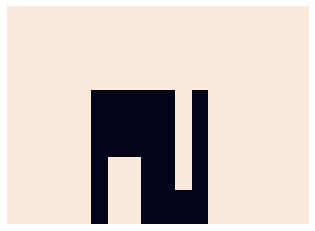

In [78]:
silhouette = 1*np.logical_not(target_maps['hand_selected_012'])
silhouette = np.rot90(silhouette)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(silhouette)

In [80]:
tm = target_maps['hand_selected_012']

In [89]:
tm[5:12,0:8] # Slice only the silhouette

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1.]])

for a current world state:
find set of viable actions

iterate through layers (keep track of floors?)
for each block find viable locations
or 
for each location find viable blocks

some of these paths will lead to dead ends

## Actual distributions of human behavior

Look at the sequences of actions people actually take
And see how close they are
Do they end up closer (by rep 4)?

Similarity:
Closer if: 
Same blocks in same place
Same blocks in same placed placed at similar time

In [103]:
dfi['usableDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
dfi['flatDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: (1+(-1)*np.array(ast.literal_eval(a))).flatten())

In [112]:
# We have sequences of world states, of length n where n is the number of blocks placed
# Each layer is a block placement
dfi['flatDiscreteWorld'][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Vector representing where blocks have been placed
Want to look at sequences of these
If people complete the silhouette, these vectors will be the same
Differing numbers of blocks mean the list of these vectors will be different lengths

I think the way to look at similarity of people's block sequences is to look at the discrete world-state and convert it into a vector (of 1s and 0s, with 1 corresponding to block-present). Then two people ending up at the same point in that space means they've build 'equivalent' structures. And the path through vector space will tell you which blocks they use, in what order, and where they were placed. 

Because people might use a different number of blocks to make the same structure, we could align all world states with the same number of 1s (i.e. the same area covered by blocks). I.e. a partial order on states.

We want: a measure of similarity between sequences. A visualization of sequences.

Visualisation: line graph with y being number of 1s, x (for now) being the number configuration 

In [125]:
dfi[(dfi.targetName=='hand_selected_012') & (dfi.phase=='pre')].group_by(by='gameID')

AttributeError: 'DataFrame' object has no attribute 'group_by'

In [142]:
xs = dfi['flatDiscreteWorld'][0]
[''.join(row) for row in xs]

TypeError: can only join an iterable

In [147]:
dfi['flatDiscreteWorld'][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [154]:
a = dfi['flatDiscreteWorld'][1]
b = dfi['flatDiscreteWorld'][8]
np.linalg.norm(a-b)

4.47213595499958

In [157]:
# get state of world at time bins (every one second?)

dfi[(dfi.targetName=='hand_selected_012') & (dfi.phase=='pre')].columns

Index(['Unnamed: 0', 'gameID', 'trialNum', 'phase', 'condition', 'eventType',
       'targetName', 'repetition', 'targetID', 'blockNum', 'nullScore',
       'incrementalScore', 'normedIncrementalScore', 'rawScoreDiscrete',
       'incrementalNormedScoreDiscretePrevious', 'score', 'currBonus',
       'timeAbsolute', 'timeRelative', 'timeBlockSelected', 'timeBlockPlaced',
       'relativePlacementTime', 'discreteWorld', 'vertices', 'blockKind',
       'blockColorID', 'blockColor', 'blockCenterX', 'blockCenterY', 'x_index',
       'y_index', 'x_discrete', 'y_discrete', 'width_discrete',
       'height_discrete', 'buggy', 'usableDiscreteWorld', 'flatDiscreteWorld'],
      dtype='object')

In [162]:
dfi[(dfi.targetName=='hand_selected_012') & (dfi.phase=='pre')].relativePlacementTime

21        5666
22       15875
23       24409
24       30681
25       38593
         ...  
10516    36298
10517    39202
10518    49170
10519    52691
10520    54827
Name: relativePlacementTime, Length: 474, dtype: int64

In [265]:
# get world state every second
# i.e. the flatDiscreteWorld for the highest time preceding i 
# for every participant, for every structure


# for one structure
#pre = dfi[(dfi.targetName=='hand_selected_012') & (dfi.phase=='pre')][['targetName','gameID','flatDiscreteWorld','relativePlacementTime']].groupby('gameID')

targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())

n_targets = df['targetName'].nunique()
n_ppts = df['gameID'].nunique()

m = np.zeros((n_targets,n_ppts,61,13*18)) #number of seconds, number of squares in grid

# for t, t_name in enumerate(targets):
#     for p, p_id in enumerate(ppts):
#         for i in range(1,61000,1000):
            
for t, t_name in enumerate(targets):
    for p, p_id in enumerate(ppts):
        subset = dfi[(dfi.targetName==t_name) & (dfi.gameID==p_id) & (dfi.phase=='pre')]
        prev_world = np.zeros(13*18)
        i = 0
        for index, row in subset.iterrows():
            while ((i*1000 < row['relativePlacementTime']) & ((i*1000)<60000)):
                m[t,p,i,:] = prev_world
                i += 1
            prev_world = row['flatDiscreteWorld']
        while (i < 60):
            m[t,p,i,:] = prev_world
            i += 1
             
#         for i in range(59000,61000,1000):
#             subset = dfi[(dfi.targetName==t_name) & (dfi.gameID==p_id) & (dfi.phase=='pre') & (dfi.relativePlacementTime<i)]
#             if subset.shape[0] > 0:
#                 m[t,p,i,:] = dfi[subset['relativePlacementTime'].idxmax()]['flatDiscreteWorld']

    

In [271]:
m[0,0,20,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [252]:
dfi[(dfi.targetName==targets[0]) & (dfi.gameID==ppts[0]) & (dfi.phase=='pre')]['flatDiscreteWorld'][30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [250]:
m[1,1,30,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.